/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode:   0 | score avg: 10.00 | memory length:   10 | epsilon: 1.0000
episode:   1 | score avg: 10.40 | memory length:   24 | epsilon: 1.0000
episode:   2 | score avg: 11.36 | memory length:   44 | epsilon: 1.0000
episode:   3 | score avg: 11.72 | memory length:   59 | epsilon: 1.0000
episode:   4 | score avg: 17.05 | memory length:  124 | epsilon: 1.0000
episode:   5 | score avg: 16.85 | memory length:  139 | epsilon: 1.0000
episode:   6 | score avg: 20.06 | memory length:  188 | epsilon: 1.0000
episode:   7 | score avg: 19.86 | memory length:  206 | epsilon: 1.0000
episode:   8 | score avg: 19.07 | memory length:  218 | epsilon: 1.0000
episode:   9 | score avg: 18.86 | memory length:  235 | epsilon: 1.0000
episode:  10 | score avg: 18.18 | memory length:  247 | epsilon: 1.0000
episode:  11 | score avg: 17.46 | memory length:  258 | epsilon: 1.0000
episode:  12 | score avg: 17.61 | memory length:  277 | epsilon: 1.0000
episode:  13 | score avg: 17.45 | memory length:  293 | epsilon:

KeyboardInterrupt: ignored

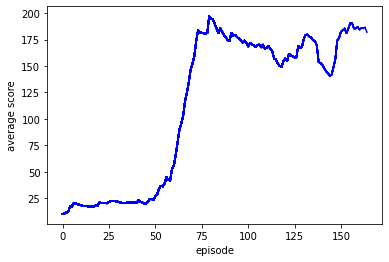

In [ ]:
import os
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform


# 상태가 입력, 큐함수가 출력인 인공신경망 생성
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size,
                            kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            # 벨만 최적 방정식을 이용한 업데이트 타깃
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))


if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    score_avg = 0

    num_episode = 300
    for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # 타임스텝마다 보상 0.1, 에피소드가 중간에 끝나면 -1 보상
            score += reward
            reward = 0.1 if not done or score == 500 else -1

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                # 에피소드마다 학습 결과 출력
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                      e, score_avg, len(agent.memory), agent.epsilon))

                # 에피소드마다 학습 결과 그래프로 저장
                scores.append(score_avg)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("average score")
                pylab.savefig("graph.png")

                # 이동 평균이 400 이상일 때 종료
                if score_avg > 400:
                    agent.model.save_weights("/content", save_format="tf")
                    sys.exit()